<a href="https://colab.research.google.com/github/vihan-lakshman/mutagenic/blob/main/masking_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluation Dataset

In [2]:
# prompt: read in '/content/prelim-deletion-validation-dataset-functional-annotations.csv'
import torch
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
df = pd.read_csv('/content/prelim-deletion-validation-dataset-functional-annotations-with-interpro.csv')

    Entry                     id  \
0  Q80WR5  sp|Q80WR5|CA174_MOUSE   
1  Q10N20   sp|Q10N20|MPK5_ORYSJ   
2  P67015    sp|P67015|SYD_STAAN   
3  P51861   sp|P51861|CDR1_HUMAN   
4  P03772     sp|P03772|PP_LAMBD   

                                            sequence  \
0  MRSRKLTGGVRSSARLRARSYSSASLASARDVTSSTSAKTTCLASS...   
1  MDGAPVAEFRPTMTHGGRYLLYDIFGNKFEVTNKYQPPIMPIGRGA...   
2  MSKRTTYCGLVTEAFLGQEITLKGWVNNRRDLGGLIFVDLRDREGI...   
3  MAWLEDVDFLEDVPLLEDIPLLEDVPLLEDVPLLEDTSRLEDINLM...   
4  MRYYEKIDGSKYRNIWVVGDLHGCYTNLMNKLDTIGFDNKKDLLIS...   

                                       truncated_seq  del_start  del_end  \
0  MRSRKLTGGVRSSARLRARSYSSASLASARDVTSSTSAKKATDRRT...         39       47   
1  MDGAPVAEFRPTMTHGGRYLLYDIFGNKFEVTNKYQPPIMPIGRGA...        274      293   
2  MSKRTTYCGLVTEAFLGQEITLKGWVNNRRDLGGLIFVDLRDREGI...         71      219   
3  MAWLEDVDFLEDVPLLEDIPLLEDVPLLEDVPLLEDTSRLEDINLM...        246      259   
4  MRYYEKIDGSKYRNIWVVGDLHGCYTNLMNKLDTIGFDNKKDLLIS...         77   

In [3]:
df.columns

Index(['Entry', 'id', 'sequence', 'truncated_seq', 'del_start', 'del_end',
       'Protein names', 'Organism', 'Length', 'EC number', 'InterPro',
       'Gene Ontology (GO)', 'Gene Ontology IDs',
       'Gene Ontology (molecular function)',
       'Gene Ontology (cellular component)',
       'Gene Ontology (biological process)', 'Subcellular location [CC]'],
      dtype='object')

In [4]:
# prompt: for each row, identify the substring that starts at del_start (counting from 1, not 0), and ends at del_end, and for each letter in that substring, it is a amino acid residue that should be randomly replaced with one of the 20 amino acids. save this as "substituted_seq" in a column after "truncated_seq"

import random

# List of standard amino acid single-letter codes
amino_acids = "ACDEFGHIKLMNPQRSTVWY"

def substitute_substring(sequence, del_start, del_end):
    """Substitutes amino acids in a substring with random amino acids."""

    # Adjust del_start to be 0-indexed
    del_start -= 1

    if del_start < 0 or del_end > len(sequence) or del_start >= del_end:
        return sequence  # Handle invalid indices

    substituted_seq = list(sequence)
    for i in range(del_start, del_end):
        substituted_seq[i] = random.choice(amino_acids)

    return "".join(substituted_seq)


# Apply the function to each row of the DataFrame
df['substituted_seq'] = df.apply(lambda row: substitute_substring(row['sequence'], row['del_start'], row['del_end']), axis=1)
df['substituted_seq'].head()

,substituted_seq
0,MRSRKLTGGVRSSARLRARSYSSASLASARDVTSSTSANTQTFFAK...
1,MDGAPVAEFRPTMTHGGRYLLYDIFGNKFEVTNKYQPPIMPIGRGA...
2,MSKRTTYCGLVTEAFLGQEITLKGWVNNRRDLGGLIFVDLRDREGI...
3,MAWLEDVDFLEDVPLLEDIPLLEDVPLLEDVPLLEDTSRLEDINLM...
4,MRYYEKIDGSKYRNIWVVGDLHGCYTNLMNKLDTIGFDNKKDLLIS...


In [5]:
df['sequence'].head()

,sequence
0,MRSRKLTGGVRSSARLRARSYSSASLASARDVTSSTSAKTTCLASS...
1,MDGAPVAEFRPTMTHGGRYLLYDIFGNKFEVTNKYQPPIMPIGRGA...
2,MSKRTTYCGLVTEAFLGQEITLKGWVNNRRDLGGLIFVDLRDREGI...
3,MAWLEDVDFLEDVPLLEDIPLLEDVPLLEDVPLLEDTSRLEDINLM...
4,MRYYEKIDGSKYRNIWVVGDLHGCYTNLMNKLDTIGFDNKKDLLIS...


In [6]:
# Dictionary to hold the results
embeddings_dict = {}

# Iterate through each row in the DataFrame
for _, row in df.iterrows():
    entry = row['Entry']
    interpro = row['InterPro']

    # Skip rows where 'Interpro' is None
    if pd.isna(interpro) or not interpro.strip():
        continue

    # Split the InterPro IDs by semicolons
    interpro_ids = interpro.split(';')
    interpro_ids = interpro_ids[:-1]

    # Initialize entry in the dictionary if not present
    if entry not in embeddings_dict:
        embeddings_dict[entry] = {
            'InterPro_ids': interpro_ids
        }


In [7]:
embeddings_dict

{'Q80WR5': {'InterPro_ids': ['IPR031530']},
 'Q10N20': {'InterPro_ids': ['IPR011009',
   'IPR050117',
   'IPR003527',
   'IPR008351',
   'IPR000719',
   'IPR017441',
   'IPR008271']},
 'P67015': {'InterPro_ids': ['IPR004364',
   'IPR006195',
   'IPR045864',
   'IPR004524',
   'IPR047089',
   'IPR002312',
   'IPR047090',
   'IPR004115',
   'IPR029351',
   'IPR012340',
   'IPR004365']},
 'P51861': {'InterPro_ids': ['IPR048506', 'IPR048507']},
 'P03772': {'InterPro_ids': ['IPR050126',
   'IPR004843',
   'IPR029052',
   'IPR006186']},
 'P33171': {'InterPro_ids': ['IPR041709',
   'IPR050055',
   'IPR004161',
   'IPR033720',
   'IPR031157',
   'IPR027417',
   'IPR005225',
   'IPR000795',
   'IPR009000',
   'IPR009001',
   'IPR004541',
   'IPR004160']},
 'B8DF05': {'InterPro_ids': ['IPR001790',
   'IPR043141',
   'IPR022973',
   'IPR047865',
   'IPR002363']},
 'Q6AAB8': {'InterPro_ids': ['IPR000941',
   'IPR036849',
   'IPR029017',
   'IPR020810',
   'IPR020809',
   'IPR020811']},
 'Q9ZMM5': 

In [8]:
pip install esm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.9 MB/s eta 0:00:00


In [9]:
from huggingface_hub import login
from esm.models.esm3 import ESM3
from esm.sdk.api import ESM3InferenceClient, ESMProtein, GenerationConfig

# Will instruct you how to get an API key from huggingface hub, make one with "Read" permission.
login()

/usr/local/lib/python3.10/dist-packages/google/cloud/storage/transfer_manager.py:30: UserWarning: The module `transfer_manager` is a preview feature. Functionality and API may change. This warning will be removed in a future release.
  warnings.warn(


In [10]:
model: ESM3InferenceClient = ESM3.from_pretrained("esm3_sm_open_v1").to("cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 22 files:   0%|          | 0/22 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/3.30k [00:00<?, ?B/s]

data/esm3_entry.list:   0%|          | 0.00/1.93M [00:00<?, ?B/s]

data/1utn.pdb:   0%|          | 0.00/569k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

data/entry_list_safety_29026.list:   0%|          | 0.00/1.60M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.00 [00:00<?, ?B/s]

hyperplanes_8bit_58641.npz:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

data/ParentChildTreeFile.txt:   0%|          | 0.00/595k [00:00<?, ?B/s]

hyperplanes_8bit_68103.npz:   0%|          | 0.00/34.9M [00:00<?, ?B/s]

data/interpro2keywords.csv:   0%|          | 0.00/7.32M [00:00<?, ?B/s]

(…)ata/interpro_29026_to_keywords_58641.csv:   0%|          | 0.00/10.1M [00:00<?, ?B/s]

(…)ord_vocabulary_safety_filtered_58641.txt:   0%|          | 0.00/788k [00:00<?, ?B/s]

keyword_idf_safety_filtered_58641.npy:   0%|          | 0.00/469k [00:00<?, ?B/s]

data/keywords.txt:   0%|          | 0.00/788k [00:00<?, ?B/s]

data/tag_dict_4.json:   0%|          | 0.00/691k [00:00<?, ?B/s]

data/tag_dict_4_safety_filtered.json:   0%|          | 0.00/569k [00:00<?, ?B/s]

tfidf_safety_filtered_58641.pkl:   0%|          | 0.00/2.02M [00:00<?, ?B/s]

(…)0_residue_annotations_gt_1k_proteins.csv:   0%|          | 0.00/109k [00:00<?, ?B/s]

esm3_function_decoder_v0.pth:   0%|          | 0.00/1.30G [00:00<?, ?B/s]

esm3_structure_decoder_v0.pth:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

esm3_sm_open_v1.pth:   0%|          | 0.00/2.80G [00:00<?, ?B/s]

esm3_structure_encoder_v0.pth:   0%|          | 0.00/62.3M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/esm/pretrained.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


In [11]:
import torch.nn as nn
from esm.tokenization import InterProQuantizedTokenizer
from esm.utils.types import FunctionAnnotation
def get_keywords_from_interpro(
    interpro_annotations,
    interpro2keywords=InterProQuantizedTokenizer().interpro2keywords,
):
    keyword_annotations_list = []
    for interpro_annotation in interpro_annotations:
        keywords = interpro2keywords.get(interpro_annotation.label, [])
        keyword_annotations_list.extend([
            FunctionAnnotation(
                label=keyword,
                start=interpro_annotation.start,
                end=interpro_annotation.end,
            )
            for keyword in keywords
        ])
    return keyword_annotations_list

In [12]:
#protein that only has one function?
#longer sequences of all As, all Gs, or completely random
def get_label_embedding(interpro_label,sequence):
  hostProtein = ESMProtein(sequence=sequence)
  embedding_function = model.encoder.function_embed
  hostProtein.function_annotations = get_keywords_from_interpro([FunctionAnnotation(label=interpro_label, start=1, end=len(sequence))])
  hostProtein_tensor = model.encode(hostProtein)
  device = hostProtein_tensor.function.device  # Get the device of protein2_tensor.function
  embedding_function = embedding_function.to(device)  # Move embedding_function to the device

  function_embed = torch.cat(
      [
          embed_fn(funcs.to(device)) # Ensure funcs is on the same device
          for embed_fn, funcs in zip(
              embedding_function, hostProtein_tensor.function.unbind(-1)
          )
      ],
      -1,
  )

  if function_embed.shape[0] >= 3:
      row_sum = function_embed.sum(dim=0)  # Sum all rows
      row_avg = row_sum / (function_embed.shape[0] - 2)  # Divide by (number of rows - 2)
      row_avg_np = row_avg.cpu().detach().type(torch.float32).numpy()
      return row_avg_np
  else:
      return None

In [13]:
import numpy as np
for entry, interpro_ids in embeddings_dict.items():
  embeddings = []
  for interpro_id in interpro_ids['InterPro_ids']:
    embeddings.append(get_label_embedding(interpro_id,"A"))
  avg_embedding = np.mean(embeddings, axis=0)
  embeddings_dict[entry]['embedding'] = avg_embedding


In [14]:
embeddings_dict

{'Q80WR5': {'InterPro_ids': ['IPR031530'],
  'embedding': array([-0.48046875, -0.31640625,  0.95703125, ...,  0.09082031,
          0.4140625 ,  1.1796875 ], dtype=float32)},
 'Q10N20': {'InterPro_ids': ['IPR011009',
   'IPR050117',
   'IPR003527',
   'IPR008351',
   'IPR000719',
   'IPR017441',
   'IPR008271'],
  'embedding': array([ 0.07560512,  0.15066965, -0.48082623, ..., -0.06509835,
          0.46777344,  0.07798549], dtype=float32)},
 'P67015': {'InterPro_ids': ['IPR004364',
   'IPR006195',
   'IPR045864',
   'IPR004524',
   'IPR047089',
   'IPR002312',
   'IPR047090',
   'IPR004115',
   'IPR029351',
   'IPR012340',
   'IPR004365'],
  'embedding': array([-0.2986062 ,  0.23703836, -0.1981534 , ...,  0.08385121,
         -0.07188832,  0.30217952], dtype=float32)},
 'P51861': {'InterPro_ids': ['IPR048506', 'IPR048507'],
  'embedding': array([-0.1328125 , -0.03613281,  0.02978516, ..., -0.14404297,
         -0.26611328, -0.7246094 ], dtype=float32)},
 'P03772': {'InterPro_ids': ['I

In [15]:
def embedding_masking_model(
    prompt,
    model,
    df,
    embeddings_dict,
    percentage=10,
):
    """
    Helper function to process a protein sequence, calculate similarities,
    and return indices for masking.

    Args:
        prompt (str): The protein sequence to be processed.
        model: The model used for protein generation and embeddings.
        df (pd.DataFrame): DataFrame containing protein data.
        embeddings_dict (dict): Dictionary storing embeddings and other details.

    Returns:
        List[int]: Indices used for masking in the sequence.
    """
    # Create an ESMProtein object
    protein = ESMProtein(sequence=prompt)

    # Configure the model for generation
    generation_config = GenerationConfig(track="function", num_steps=8)

    # Generate the protein
    generated_protein = model.generate(protein, generation_config)

    # Check if function annotations are available
    entry = df.loc[df['substituted_seq'] == prompt, 'Entry'].iloc[0]
    if generated_protein.function_annotations is None:
        embeddings_dict[entry]['hamming_distance'] = None
        return []

    # Getting embedding for the protein
    protein_tensor = model.encode(generated_protein)
    embedding_function = model.encoder.function_embed
    device = protein_tensor.function.device  # Get the device of protein_tensor.function
    embedding_function = embedding_function.to(device)  # Move embedding_function to the device

    function_embed = torch.cat(
        [
            embed_fn(funcs.to(device))  # Ensure funcs is on the same device
            for embed_fn, funcs in zip(
                embedding_function, protein_tensor.function.unbind(-1)
            )
        ],
        -1,
    )

    # Exclude start and end tokens
    function_embed = function_embed[1:-1, :]

    # Convert the protein_tensor.function to a NumPy array
    protein_np = function_embed.cpu().detach().type(torch.float32).numpy()

    # Retrieve target sequence and embedding
    embedding = embeddings_dict[entry]['embedding']

    # Calculate cosine similarity
    similarities = cosine_similarity(protein_np, embedding.reshape(1, -1))

    num_indices = int(len(prompt) * percentage / 100)

    # Ensure we select at least 1 index
    num_indices = max(1, num_indices)

    # Find the top 10 indices with the lowest cosine similarity
    indices = np.argsort(similarities.flatten())[:num_indices]

    # Store the indices in the embeddings_dict
    embeddings_dict[entry]['indices'] = indices.tolist()

    return indices.tolist()

In [16]:
def get_random_indices(prompt, percentage):
    """
    Randomly select indices to mask based on the percentage of the prompt's length.
    """
    num_indices = int(len(prompt) * percentage / 100)
    # Ensure we select at least one index
    num_indices = max(1, num_indices)

    # Randomly select unique indices to mask
    return random.sample(range(len(prompt)), num_indices)

In [18]:
for idx, prompt in enumerate(df['substituted_seq']):
    random_indices = get_random_indices(prompt, 8)
    # Replace locations in prompt corresponding to indices in 'indices' with "_"
    target_seq = df.loc[df['substituted_seq'] == prompt, 'sequence'].iloc[0]
    for method in ['embedding', 'random']:
      if method == 'embedding':
        indices = embedding_masking_model(prompt, model, df, embeddings_dict,percentage=8)
        if not indices:
          continue
      elif method == 'random':
        indices = get_random_indices(prompt, 8)
      modified_prompt = list(prompt)
      for index in indices:
          modified_prompt[index] = "_"
      modified_prompt = "".join(modified_prompt)
      protein_prompt = ESMProtein(sequence=modified_prompt)
      sequence_generation = model.generate(
          protein_prompt,
          GenerationConfig(
              track="sequence",
              num_steps=protein_prompt.sequence.count("_") // 2,
              temperature=0.5,
          ),
      )
      print("Generated Sequence: " + str(sequence_generation.sequence))
      generated_sequence = sequence_generation.sequence
      print("Target Sequence: " + str(target_seq))
      # Ensure sequences are of equal length
      if len(generated_sequence) != len(target_seq):
          raise ValueError("Sequences must be of the same length to calculate Hamming distance.")

      # Calculate Hamming distance
      hamming_distance = sum(1 for gen, target in zip(generated_sequence, target_seq) if gen != target)

      # Print results
      print("Hamming Distance:", hamming_distance)
      embeddings_dict[entry][f'{method}_hamming_distance'] = hamming_distance


100%|██████████| 9/9 [00:02<00:00,  3.28it/s]


Generated Sequence: MRSRKLTGGVRSSARLRARSYSSASLASARDVTESTSANTQTSFAKPHKATDRRTSKKFKYDKGHLVKAELQKLDIKSDISSLPKPAPVAPCENKFAEDSAEAAVSPPESVTPPQGCSTPASEEPSVKAENGESTEPSSAAPAQEPDDSSAGQAEPVPETEEVRPSVLQDDSSIFLDADSNQDMPVSDFFGNSELMQDLPPASPSYPSMSRREFRKMHFRAKDDEDDAEG
Target Sequence: MRSRKLTGGVRSSARLRARSYSSASLASARDVTSSTSAKTTCLASSSHKATDRRTSKKFKYDKGHLVKAELQKLDPKSDISSLPKVAPVAPCENKFAEDSAEAAVSVPESREPPQGCSTPASEEPSVKAENGLSTEPSSAAAAQEPDDSSAGQAEPVPRTEEVRASVLQMDSSIFLDDDSNQPMPVSRFFGNVELMQDLPPASSSYPSMSRREFRKMHFRAKDDEDDAEG
Hamming Distance: 24


100%|██████████| 14/14 [00:06<00:00,  2.07it/s]


Generated Sequence: MDGAPVAEFRPTMTHGGRYLLYDIFGNKFEVTNKYQPPIMPIGRGAYGIVCSVMNFETREMVAIKKIANAFNNDMDAKRTLREIKLLRHLDHENIIGIRDVIPPPIPQAFNDVYIATELMDTDLHHIIRSNQELSEEHCQYFLYQILRGLKYIHSANVIHRDLKPSNLLLNANCDLKICDFGLARPSSESDMMTEYVVTRWYRAPELLLNSTDYSAAIDVWSVGCIFMELINRQPLFPGRDHMHQMRLITEVIGTPTDDELGFIRNEDARKYMIVHYDFVMKSNRYIYDSFSEAALDLIERMLTFNPLQRITVEEALDHPYLERLHDPDDEPVAPTMFDFSFDEENLNEDQMKQLIFNEAKEYPPRIRF
Target Sequence: MDGAPVAEFRPTMTHGGRYLLYDIFGNKFEVTNKYQPPIMPIGRGAYGIVCSVMNFETREMVAIKKIANAFNNDMDAKRTLREIKLLRHLDHENIIGIRDVIPPPIPQAFNDVYIATELMDTDLHHIIRSNQELSEEHCQYFLYQILRGLKYIHSANVIHRDLKPSNLLLNANCDLKICDFGLARPSSESDMMTEYVVTRWYRAPELLLNSTDYSAAIDVWSVGCIFMELINRQPLFPGRDHMHQMRLITEVIGTPTDDELGFIRNEDARKYMRHLPQYPRRTFASMFPRVQPAALDLIERMLTFNPLQRITVEEALDHPYLERLHDIADEPICLEPFSFDFEQKALNEDQMKQLIFNEAIEMNPNIRY
Hamming Distance: 38


100%|██████████| 14/14 [00:06<00:00,  2.06it/s]


Generated Sequence: MDGAPVAEFRPEMTHGGRYLLYDIFGNKFEVTNKFAPPIMPIGRGAYGIVCSVMNFETREMVAIKKIANAFNNDMDAKRTLREIKLLRHLDHPNIINIRDVIPPPIPQAFNDVYIATELMDTDLHHIIRSNQELSEEHCQYFLYQILRGLKYIHSANVIHRDLKPSNLLLNANCDLKICDFGLARPSSESDIMTEYVVTRWYRAPELLLNSTDYTAAIDIWSVGCIFMEMITRQPLFPGRDHIHQMRLITEVIGGPTDDELGFIRNDDARKYMIVHYDFVMKRNRYFFDSFSEAALDLIEKMLTFNPLQRITVEEALDHPYLERLHDIADEPICLEPFSFDFEQKALNEDQMKQLIFNEAIEMNPNKRY
Target Sequence: MDGAPVAEFRPTMTHGGRYLLYDIFGNKFEVTNKYQPPIMPIGRGAYGIVCSVMNFETREMVAIKKIANAFNNDMDAKRTLREIKLLRHLDHENIIGIRDVIPPPIPQAFNDVYIATELMDTDLHHIIRSNQELSEEHCQYFLYQILRGLKYIHSANVIHRDLKPSNLLLNANCDLKICDFGLARPSSESDMMTEYVVTRWYRAPELLLNSTDYSAAIDVWSVGCIFMELINRQPLFPGRDHMHQMRLITEVIGTPTDDELGFIRNEDARKYMRHLPQYPRRTFASMFPRVQPAALDLIERMLTFNPLQRITVEEALDHPYLERLHDIADEPICLEPFSFDFEQKALNEDQMKQLIFNEAIEMNPNIRY
Hamming Distance: 34


100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 148.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 105.06 MiB is free. Process 37384 has 14.64 GiB memory in use. Of the allocated memory 13.57 GiB is allocated by PyTorch, and 965.69 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

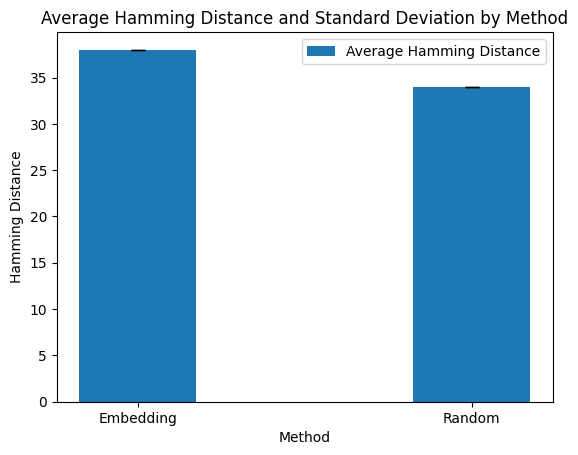

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Extract Hamming distances for 'embedding' and 'random' methods
embedding_distances = []
random_distances = []

# Iterate over embeddings_dict to gather the hamming distances
for entry in embeddings_dict.values():
    embedding_distance = entry.get('embedding_hamming_distance', None)
    random_distance = entry.get('random_hamming_distance', None)

    # Skip None values and collect valid distances
    if embedding_distance is not None:
        embedding_distances.append(embedding_distance)
    if random_distance is not None:
        random_distances.append(random_distance)

# Calculate average and standard deviation for both methods
embedding_avg = np.mean(embedding_distances) if embedding_distances else 0
embedding_std = np.std(embedding_distances) if embedding_distances else 0

random_avg = np.mean(random_distances) if random_distances else 0
random_std = np.std(random_distances) if random_distances else 0

# Prepare data for the bar plot
methods = ['Embedding', 'Random']
averages = [embedding_avg, random_avg]
std_devs = [embedding_std, random_std]

# Create the bar plot
fig, ax = plt.subplots()

# Set positions for the bars
bar_width = 0.35
index = np.arange(len(methods))

# Plot the bars with error bars
ax.bar(index, averages, bar_width, yerr=std_devs, capsize=5, label='Average Hamming Distance')

# Customize the plot
ax.set_xlabel('Method')
ax.set_ylabel('Hamming Distance')
ax.set_title('Average Hamming Distance and Standard Deviation by Method')
ax.set_xticks(index)
ax.set_xticklabels(methods)
ax.legend()

# Display the plot
plt.show()